# Copyright Notice

```
SPDX-FileCopyrightText: Copyright (c) 1993-2025 NVIDIA CORPORATION & AFFILIATES. All rights reserved.
SPDX-License-Identifier: Apache-2.0

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
```


# VLM-Finetuning for Large Scale Data Analysis

### 📓 Notebook Overview 
In this notebook, we show how to train a VLM to genreate structured metadata about videos. The use case we target is using a VLM to analyze driving videos to generate json-formatted video descriptions and metadata like risky maneuvers to understand dangerous driving patterns. 

This is just one example, this workflow can be generalized to any large scale video data analysis task where it's helpful to have structured metadata and automated video analysis.

### Intitialize Imports

In [ ]:
import logging

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__) 

import os

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"   
os.environ["TORCH_USE_CUDA_DSA"] = "1"

import sys
import json
import random
import pathlib

import torch
import numpy as np
from PIL import Image
from decord import VideoReader
import torch.nn.functional as F
from datasets import load_dataset
from transformers.utils import hub
from tensorboard import program
import torchvision.transforms as T
from IPython.display import display

from trl import SFTTrainer, SFTConfig
from peft import LoraConfig, get_peft_model
from transformers.trainer_pt_utils import LabelSmoother
from transformers.trainer_utils import get_last_checkpoint
from transformers import AutoModelForCausalLM, AutoTokenizer
from torchvision.transforms.functional import InterpolationMode
from transformers import AutoModelForCausalLM, AutoTokenizer

/usr/local/lib/python3.12/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Appended utils/ to path


In [ ]:
# Set seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


set_seed(42)

Starting GPU monitor...
Logging every 5 seconds to logs/gpu-util.csv


[WARNING] NVML Error: Not Supported
[WARNING] NVML Error: Not Supported
[WARNING] NVML Error: Not Supported
[WARNING] NVML Error: Not Supported
[WARNING] NVML Error: Not Supported
[WARNING] NVML Error: Not Supported
[WARNING] NVML Error: Not Supported
[WARNING] NVML Error: Not Supported
[WARNING] NVML Error: Not Supported
[WARNING] NVML Error: Not Supported
[WARNING] NVML Error: Not Supported
[WARNING] NVML Error: Not Supported
[WARNING] NVML Error: Not Supported
[WARNING] NVML Error: Not Supported
[WARNING] NVML Error: Not Supported
[WARNING] NVML Error: Not Supported
[WARNING] NVML Error: Not Supported
[WARNING] NVML Error: Not Supported
[WARNING] NVML Error: Not Supported
[WARNING] NVML Error: Not Supported
[WARNING] NVML Error: Not Supported
[WARNING] NVML Error: Not Supported
[WARNING] NVML Error: Not Supported
[WARNING] NVML Error: Not Supported
[WARNING] NVML Error: Not Supported
[WARNING] NVML Error: Not Supported
[WARNING] NVML Error: Not Supported
[WARNING] NVML Error: Not Su

In [ ]:
# Set some constants
seq_len = 8192
model_name = "OpenGVLab/InternVL3-8B"
ignore_token_id = LabelSmoother.ignore_index

### Model Loading

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
    model_name, 
    trust_remote_code=True,
    use_fast=True
)
tokenizer.padding_side = "right"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    trust_remote_code=True,
    use_flash_attn=True,
)

# Load the processor
processor = AutoProcessor.from_pretrained(
    model_name,
    trust_remote_code=True,
)

`torch_dtype` is deprecated! Use `dtype` instead!
2025-09-18 01:02:24,054 - INFO - vision_select_layer: -1
2025-09-18 01:02:24,055 - INFO - ps_version: v2
2025-09-18 01:02:24,055 - INFO - min_dynamic_patch: 1
2025-09-18 01:02:24,056 - INFO - max_dynamic_patch: 12
2025-09-18 01:02:24,057 - INFO - vision_config is None. Initializing the InternVisionConfig with default values.
2025-09-18 01:02:24,058 - INFO - llm_config is None. Initializing the LlamaConfig config with default values (`LlamaConfig`).
2025-09-18 01:02:24,059 - INFO - vision_select_layer: -1
2025-09-18 01:02:24,059 - INFO - ps_version: v1
2025-09-18 01:02:24,060 - INFO - min_dynamic_patch: 1
2025-09-18 01:02:24,060 - INFO - max_dynamic_patch: 6
2025-09-18 01:02:24,183 - INFO - Discovered apex.normalization.FusedRMSNorm - will use it instead of InternRMSNorm
2025-09-18 01:02:24,187 - INFO - num_image_token: 256
2025-09-18 01:02:24,188 - INFO - ps_version: v2
2025-09-18 01:02:24,374 - INFO - We will use 90% of the memory on d

trainable params: 4,399,104 || all params: 634,097,024 || trainable%: 0.6938


### Data Processing

**Action Required**: Please update the `dataset_path` with a path to your local dataset.

In [ ]:
dataset_path = "/lustre/fsw/portfolios/general/users/lramesh/internvl_inference/nexar_scap_dataset_v2"
if os.path.exists(dataset_path):
    print('true')

true


In [ ]:
# Load conversation template
model_dir = hub.cached_file(model_name, "conversation.py", trust_remote_code=True)
sys.path.append(os.path.dirname(model_dir))

from conversation import get_conv_template

In [ ]:
def get_jsonl_data(sample): 
    """ Data processing helper: Define the labels based on the desired format we hope to teach 
        the model to generate 
    """
    answer_dict = {
        "caption": sample['caption'],
        "event_type": sample['event_type'],
        "rule_violations": sample['rule_violations'],
        "intended_action": sample['intended_action'],
        "traffic_density": sample['traffic_density'],
        "scene": sample['scene'],
        "visibility": sample['visibility'],
    }

    return json.dumps(answer_dict, ensure_ascii=False)  # create a single line, valid JSON

### Load the Dataset

In [ ]:
# Load the dataset
dataset = load_dataset(dataset_path)
dataset = dataset['train']
dataset = dataset.map(lambda ex: {"labels": get_jsonl_data(ex)})
ds_splits = dataset.train_test_split(test_size=0.01, seed=42)
train_dataset, val_dataset = ds_splits['train'], ds_splits['test']

Generating train split: 4513 examples [00:00, 490220.75 examples/s]
Map: 100%|██████████| 4513/4513 [00:00<00:00, 16999.53 examples/s]


In [10]:
dataset

Dataset({
    features: ['video', 'caption', 'event_type', 'cause_of_risk', 'presence_of_rule_violations', 'intended_driving_action', 'traffic_density', 'driving_setting', 'time_of_day', 'light_conditions', 'weather', 'scene', 'chunk_metadata', 'original_metadata', 'labels'],
    num_rows: 4513
})

In [11]:
train_dataset

Dataset({
    features: ['video', 'caption', 'event_type', 'cause_of_risk', 'presence_of_rule_violations', 'intended_driving_action', 'traffic_density', 'driving_setting', 'time_of_day', 'light_conditions', 'weather', 'scene', 'chunk_metadata', 'original_metadata', 'labels'],
    num_rows: 4061
})

### Data Visualization

In [13]:
def get_video_path(dataset_path, sample_path):
    """ Dataset speciic helper function -- this appends the sample path to the root path to create the full video path """
    root_dir = dataset_path.split('/')[:-1]
    video_path = '/'.join(root_dir) + '/' + sample_path
    return video_path

In [14]:
min_frames, max_frames = 8, 32

# load frames from a video
def load_video(video_path):
    video = VideoReader(video_path, num_threads=1)

    # sample a random number of equally-spaced frames from the video
    frame_indices = np.linspace(
        0,
        len(video) - 1,
        random.randint(min_frames, max_frames),
        dtype=int
    )
    frames = video.get_batch(frame_indices).asnumpy()
    return [Image.fromarray(frames[i]) for i in range(frames.shape[0])]

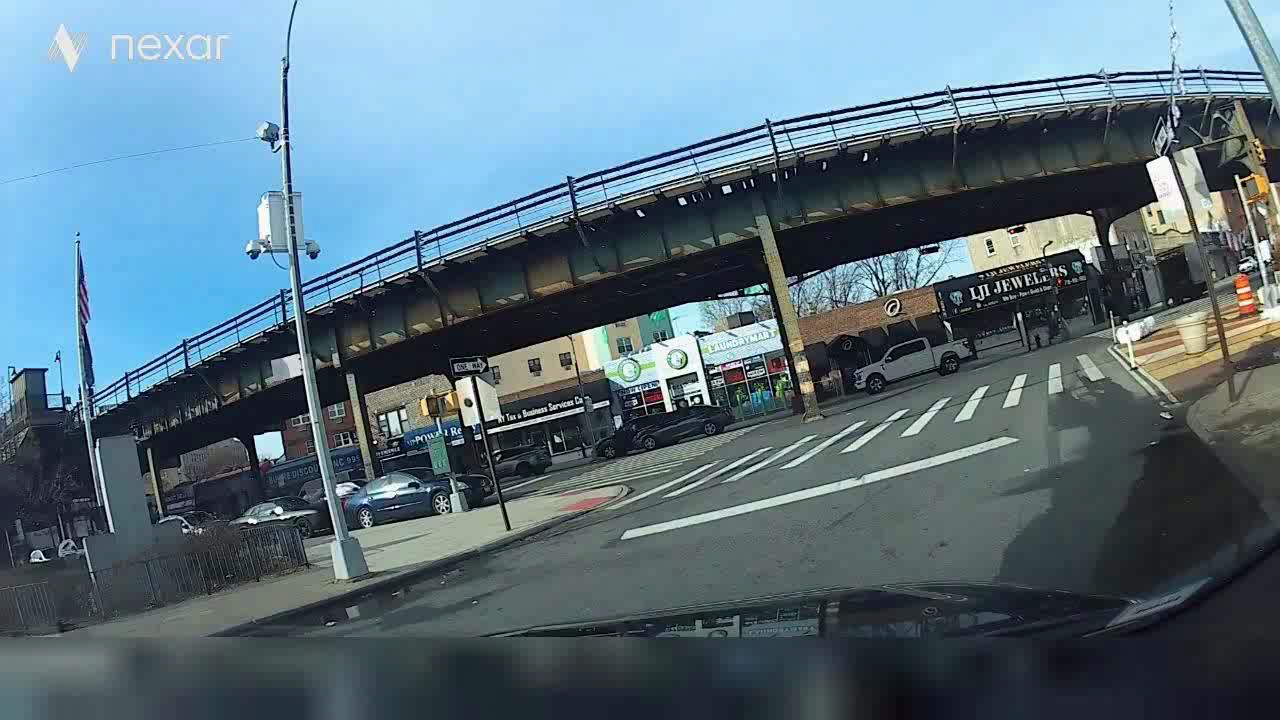

In [15]:
video_path = get_video_path(dataset_path, train_dataset[0]['video'])
display(load_video(video_path)[0])

### Data Processing
Functions taken from [InternVL3 Documentation](https://internvl.readthedocs.io/en/latest/internvl3.0/quick_start.html#inference-with-transformers)

In [16]:
# preprocessing code directly adopted HF model card
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)


def build_transform(input_size):
    MEAN, STD = IMAGENET_MEAN, IMAGENET_STD
    transform = T.Compose([
        T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
        T.Resize((input_size, input_size), interpolation=InterpolationMode.BICUBIC),
        T.ToTensor(),
        T.Normalize(mean=MEAN, std=STD)
    ])
    return transform


def find_closest_aspect_ratio(aspect_ratio, target_ratios, width, height, image_size):
    best_ratio_diff = float('inf')
    best_ratio = (1, 1)
    area = width * height
    for ratio in target_ratios:
        target_aspect_ratio = ratio[0] / ratio[1]
        ratio_diff = abs(aspect_ratio - target_aspect_ratio)
        if ratio_diff < best_ratio_diff:
            best_ratio_diff = ratio_diff
            best_ratio = ratio
        elif ratio_diff == best_ratio_diff:
            if area > 0.5 * image_size * image_size * ratio[0] * ratio[1]:
                best_ratio = ratio
    return best_ratio


def dynamic_preprocess(image, min_num=1, max_num=12, image_size=448, use_thumbnail=False):
    orig_width, orig_height = image.size
    aspect_ratio = orig_width / orig_height

    # calculate the existing image aspect ratio
    target_ratios = set(
        (i, j) for n in range(min_num, max_num + 1) for i in range(1, n + 1) for j in range(1, n + 1) if
        i * j <= max_num and i * j >= min_num)
    target_ratios = sorted(target_ratios, key=lambda x: x[0] * x[1])

    # find the closest aspect ratio to the target
    target_aspect_ratio = find_closest_aspect_ratio(
        aspect_ratio, target_ratios, orig_width, orig_height, image_size)

    # calculate the target width and height
    target_width = image_size * target_aspect_ratio[0]
    target_height = image_size * target_aspect_ratio[1]
    blocks = target_aspect_ratio[0] * target_aspect_ratio[1]

    # resize the image
    resized_img = image.resize((target_width, target_height))
    processed_images = []
    for i in range(blocks):
        box = (
            (i % (target_width // image_size)) * image_size,
            (i // (target_width // image_size)) * image_size,
            ((i % (target_width // image_size)) + 1) * image_size,
            ((i // (target_width // image_size)) + 1) * image_size
        )
        # split the image
        split_img = resized_img.crop(box)
        processed_images.append(split_img)
    assert len(processed_images) == blocks
    if use_thumbnail and len(processed_images) != 1:
        thumbnail_img = image.resize((image_size, image_size))
        processed_images.append(thumbnail_img)
    return processed_images


# build the transform and get number of tokens per image (per tile technically)
image_size = model.config.force_image_size
transform = build_transform(input_size=image_size)
num_image_tokens = int((image_size // model.config.vision_config.patch_size) ** 2 * (model.config.downsample_ratio ** 2))

### Define user prompt

In [ ]:
user_prompt = """You are a vision-language assistant analyzing driving videos. You will receive a 5-second video clip of a specific scene. 

---

### Task 1: Dense Caption
Generate a 2 sentence caption describing:
- Ego vehicle behavior
- Interactions with other vehicles or pedestrians

Focus on **what happens**, **when**, and **who/what is involved**, using only visible information and metadata.

---

### Task 2: Structured JSON
Generate the caption from the perspective of the ego vehicle in a structured JSON object with:

- `"caption"`: from Task 1  
- `"event_type"`: "collision" | "near_miss" | "no_incident"  
- `"rule_violations"`: choose relevant items from ["speeding", "failure_to_yield", "ignoring_traffic_signs"]  
- `"intended_action"`: "turn_left" | "turn_right" | "change_lanes"  
- `"traffic_density"`: "low" | "high"  
- `"visibility"`: "good" | "bad"  
- `"scene"`: "Urban" | "Sub-urban" | "Rural" | "Highway"

**Rules:**
1. Use only visible info and metadata.  
2. Do not invent details.  
3. Include all fields; enum values must match allowed options.  
4. Output a single valid JSON object—no extra text or markdown.  
"""

In [ ]:
# View a sample label to confirm it's in the format we want
sample = train_dataset[0]

answer_dict = {
    "caption": sample['caption'],
    "event_type": sample['event_type'],
    "rule_violations": sample['rule_violations'],
    "intended_action": sample['intended_action'],
    "traffic_density": sample['traffic_density'],
    "scene": sample['scene'],
    "visibility": sample['visibility'],
}
answer_jsonl = json.dumps(answer_dict, ensure_ascii=False)

print(answer_jsonl)

{"caption": "The video shows a stationary vehicle at an urban intersection under a bridge. There are no significant movements or interactions with other vehicles or pedestrians, and the scene remains calm with clear weather conditions.", "event_type": "no_incident", "cause_of_risk": [], "presence_of_rule_violations": [], "intended_driving_action": "enter_road", "traffic_density": "low", "driving_setting": "intersection", "time_of_day": "day", "light_conditions": "Normal", "weather": "Clear", "scene": "Urban"}


### Custom Data Preprocessing

This novel data tokenization function takes in a batch of samples and tokenizes them according to what InternVL3 source code expects, returning a processed batch of features with input IDs, labels, attention masks, etc.

In [ ]:
# Collate function for the dataset that does on-the-fly preprocessing and batching
def collate_fn(samples, tokenizer, transform, seq_len, num_image_tokens, get_conv_template, ignore_token_id, load_video, get_video_path, dataset_path):
    input_ids_batch, labels_batch, attention_mask_batch, position_ids_batch, pixel_values_batch, image_flags_batch = [], [], [], [], [], []
    for sample in samples:
        # load the video frames
        video_frames = load_video(get_video_path(dataset_path, sample['video']))
        num_frames = len(video_frames)

        # preprocess the video frames
        pixel_values = [transform(frame) for frame in video_frames]
        pixel_values = torch.stack(pixel_values)
        num_tiles = pixel_values.size(0)

        # prepend special video tokens to the user message
        video_tokens = '\n'.join(['Frame-{}: <image>'.format(i + 1) for i in range(num_frames)])

        # setup conversation
        conv_template = get_conv_template("internvl2_5")

        system_instruction = user_prompt
        answer = get_jsonl_data(sample)

        conv_template.append_message(conv_template.roles[0], f'{video_tokens}\n{system_instruction}')
        conv_template.append_message(conv_template.roles[1], answer)

        # replace image tokens with context tokens
        prompt = conv_template.get_prompt()
        prompt = prompt.replace("<image>", f"<img>{'<IMG_CONTEXT>' * num_image_tokens}</img>")

        # create a list of messages
        messages = [f"<|im_start|>{message}" for message in prompt.split("<|im_start|>")[1: ]]

        # tokenize the prompt (we manually truncate and pad the sequence)
        input_ids = tokenizer(
            messages,
            return_tensors="np",
            padding=False,
            max_length=seq_len,
            truncation=False,
        ).input_ids

        # create targets by masking out system and user messages
        # since we only want to compute loss for the assistant message
        targets = []
        num_ignore_ids = tokenizer('<|im_start|>assistant\n', return_tensors='np').input_ids[0].shape[0]
        for idx, input_id in enumerate(input_ids):
            if idx != 2:
                targets.append(np.full(input_id.shape, ignore_token_id))
            else:
                target = input_id.copy()
                target[: num_ignore_ids] = ignore_token_id
                target[-1: ] = ignore_token_id
                targets.append(target)

        # prepare the input_ids and targets
        input_ids = torch.tensor(np.concatenate(input_ids))[: seq_len]
        targets = torch.tensor(np.concatenate(targets))[: seq_len]

        # pad the input_ids and targets to the sequence length
        pad_len = seq_len - input_ids.shape[0]
        input_ids = F.pad(input_ids, (0, pad_len), value=tokenizer.pad_token_id)
        targets = F.pad(targets, (0, pad_len), value=ignore_token_id)

        # generate attention mask to filter out padding tokens
        attention_mask = input_ids.ne(tokenizer.pad_token_id)

        position_ids = attention_mask.long().cumsum(-1) - 1
        position_ids.masked_fill_(attention_mask == 0, 1)

        input_ids_batch.append(input_ids)
        labels_batch.append(targets)
        attention_mask_batch.append(attention_mask)
        position_ids_batch.append(position_ids)
        pixel_values_batch.append(pixel_values)
        image_flags_batch.append(torch.tensor([1] * num_tiles, dtype=torch.long))

    batch = {
        "input_ids": torch.stack(input_ids_batch),
        "labels": torch.stack(labels_batch),
        "attention_mask": torch.stack(attention_mask_batch),
        "position_ids": torch.stack(position_ids_batch),
        "pixel_values": torch.cat(pixel_values_batch),
        "image_flags": torch.cat(image_flags_batch)
    }

    return batch

## Training

### Set Model Config Params for Training

In [ ]:
model.img_context_token_id = tokenizer.convert_tokens_to_ids("<IMG_CONTEXT>")

model.train()

model.language_model.config.use_cache = False
model.vision_model.gradient_checkpointing = True
model.vision_model.encoder.gradient_checkpointing = True
model.language_model._set_gradient_checkpointing()

### Define Training Params

In [ ]:
save_dir = "eval-run-1" # feel free to adjust

trainer = SFTTrainer(
    model=model,
    data_collator=collate_fn,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    processing_class=processor,
    args=SFTConfig(
        num_train_epochs=30,
        per_device_train_batch_size=1,
        per_device_eval_batch_size=1,
        eval_steps=250,
        do_eval=True,
        warmup_ratio=0.03,
        lr_scheduler_type="cosine",
        eval_strategy="steps",
        label_names=["labels"],
        dataloader_num_workers=4,
        gradient_accumulation_steps=4,
        dataloader_persistent_workers=True,
        learning_rate=2e-5,
        weight_decay=0.05,
        logging_steps=10,
        logging_dir="logs",
        save_strategy="steps",
        save_steps=100,
        output_dir=save_dir,
        save_total_limit=2,
        optim="adamw_torch",
        bf16=True,
        remove_unused_columns=False,
        report_to="wandb",
        dataset_kwargs = {"skip_prepare_dataset": True},

    )
)

### Train the model
**Note:** Remove the `resume_from_checkpoint` parameter of `trainer.train()` if you don't want to resume training from a checkpoint.

In [23]:
last_ckpt = get_last_checkpoint(save_dir)
print(f"Resuming from {last_ckpt}")
trainer.train(resume_from_checkpoint=last_ckpt)

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 151645, 'pad_token_id': 151643}.
2025-09-18 01:02:39,337 - INFO - vision_config is None. Initializing the InternVisionConfig with default values.
2025-09-18 01:02:39,339 - INFO - llm_config is None. Initializing the LlamaConfig config with default values (`LlamaConfig`).
2025-09-18 01:02:39,339 - INFO - vision_select_layer: -1
2025-09-18 01:02:39,340 - INFO - ps_version: v1
2025-09-18 01:02:39,340 - INFO - min_dynamic_patch: 1
2025-09-18 01:02:39,340 - INFO - max_dynamic_patch: 6


Resuming from None


/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:893: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss,Validation Loss


2025-09-18 01:27:08,429 - INFO - vision_config is None. Initializing the InternVisionConfig with default values.
2025-09-18 01:27:08,429 - INFO - llm_config is None. Initializing the LlamaConfig config with default values (`LlamaConfig`).
2025-09-18 01:27:08,430 - INFO - vision_select_layer: -1
2025-09-18 01:27:08,430 - INFO - ps_version: v1
2025-09-18 01:27:08,430 - INFO - min_dynamic_patch: 1
2025-09-18 01:27:08,430 - INFO - max_dynamic_patch: 6
2025-09-18 01:27:08,431 - INFO - vision_config is None. Initializing the InternVisionConfig with default values.
2025-09-18 01:27:08,431 - INFO - llm_config is None. Initializing the LlamaConfig config with default values (`LlamaConfig`).
2025-09-18 01:27:08,431 - INFO - vision_select_layer: -1
2025-09-18 01:27:08,431 - INFO - ps_version: v1
2025-09-18 01:27:08,431 - INFO - min_dynamic_patch: 1
2025-09-18 01:27:08,431 - INFO - max_dynamic_patch: 6
2025-09-18 01:27:08,433 - INFO - vision_config is None. Initializing the InternVisionConfig with

KeyboardInterrupt: 